# DTW Preprocessing Workflow
Midi -> audio -> CQT -> log-magnitude -> $L^2$ normalize -> distance matrix

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
from scripts.midi.MidiLoader import MidiLoader
from scripts.midi.MidiSynth import MidiSynth
from scripts.midi.MidiPlayer import MidiPlayer

from scripts.audio.AudioPlayer import AudioPlayer

from scripts.dtw.MidiDTW import MidiDTW

## Listen to the query (MIDI) vs. the template (ME)

Our goal is to warp the MIDI note lengths to match the user's recorded audio note lengths so we can easily compare pitches just by jumping to a point in the midifile.

In [138]:
# To inspect how MIDI file is currently parsed
# message_dict, program_dict, pitch_df = MidiLoader.parse_midi('data/fugue_midi.mid')

# Initialize a MidiSynth + MidiPlayer with a given soundfont
SOUNDFONT = 'data/MuseScore_General.sf3'
midi_synth = MidiSynth(soundfont_path=SOUNDFONT)
midi_player = MidiPlayer(midi_synth)

# Play a given midi file
MIDI_FILEPATH = 'data/midi_files/fast_fugue_midi.mid'
midi_player.load_midi(MIDI_FILEPATH)
midi_player.play(start_time=0)

In [139]:
# Play the template audio
audio_player = AudioPlayer()

# Play a given audio file
AUDIO_FILEPATH = 'data/audio_files/fugue_recording.mp3'
audio_player.load_audio(AUDIO_FILEPATH)
audio_player.play()

## Step 1: Load audio data

MIDI and audio can be compared with DTW by converting both into intermediary representation. 

This is commonly done through synthesizing MIDI to get audio signals and comparing a common spectral transform of the audio file and the synthesized MIDI audio.

### 1a. Convert MIDI to audio buffer

Uses pretty_midi for ease of converting MIDI to audio

In [140]:
import pretty_midi
import soundfile as sf

def midi_to_audio(midi_file_path, save_audio=False):
    FS_SAMPLE_RATE = 22050
    SOUNDFONT = 'data/MuseScore_General.sf3'

    midi_obj = pretty_midi.PrettyMIDI(midi_file_path)
    midi_audio = midi_obj.fluidsynth(fs=FS_SAMPLE_RATE, sf2_path=SOUNDFONT)

    # Write the audio to a file (optional)
    if save_audio is True:
        CONVERTED_MIDI_FILEPATH = midi_file_path.replace('.mid', '.mp3')
        sf.write(CONVERTED_MIDI_FILEPATH, midi_audio, FS_SAMPLE_RATE)

    return midi_audio

MIDI_FILEPATH = 'data/midi_files/fast_fugue_midi.mid'
midi_audio = midi_to_audio(MIDI_FILEPATH)

### 1b. Load user audio recording

Uses `librosa.load` for convenience

In [141]:
import librosa

AUDIO_FILEPATH = 'data/fugue_recording.mp3'
FS_SAMPLE_RATE = 22050

# Load the MP3 file
user_audio, user_sample_rate = librosa.load(AUDIO_FILEPATH, sr=FS_SAMPLE_RATE)  # sr=None preserves the original sample rate
# user_sample_rate = 22050
# user_audio = midi_to_audio('data/midi_files/fugue_midi.mid')

## Step 2: Compute the CQT of audio data

CQT, or Constant-Q transform, represents the amount of energy in logarithmically spaced bins

Raffel, Ellis 2016 uses a constant-Q spectra spanning 4 octaves starting from MIDI note C2 (65.4 Hz) with 12 bins / octave.

In [142]:
import numpy as np
import matplotlib.pyplot as plt

def display_cqt(cqt):
    """ Plot a CQT with sane defaults """
    plt.imshow(cqt.T, aspect='auto', interpolation='nearest',
               origin='lower', cmap=plt.cm.hot,
               vmin=np.percentile(cqt, 5), vmax=np.percentile(cqt, 95))
    plt.xlabel('Frame')
    plt.ylabel('Frequency bin')

In [143]:
midi_cqt, midi_times = MidiDTW.extract_cqt(midi_audio)
user_cqt, user_times = MidiDTW.extract_cqt(user_audio)

/Users/sarah/Desktop/shasha/midi-dtw/scripts/dtw/PreprocessDTW.py:75: ComplexWarning: Casting complex values to real discards the imaginary part
  cqt = cqt.astype(np.float32) # Store CQT as float32 to save space/memory


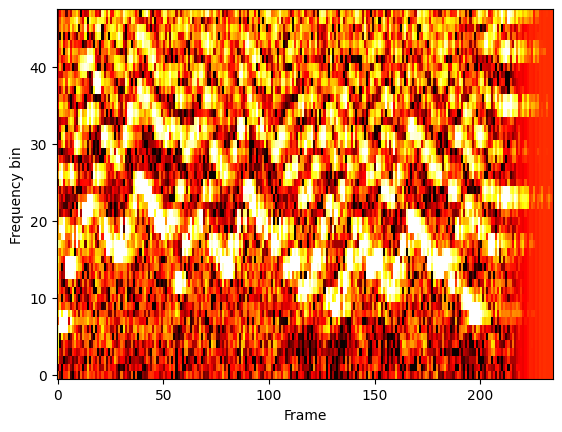

In [144]:
display_cqt(midi_cqt)

### 2b. CQT of user audio

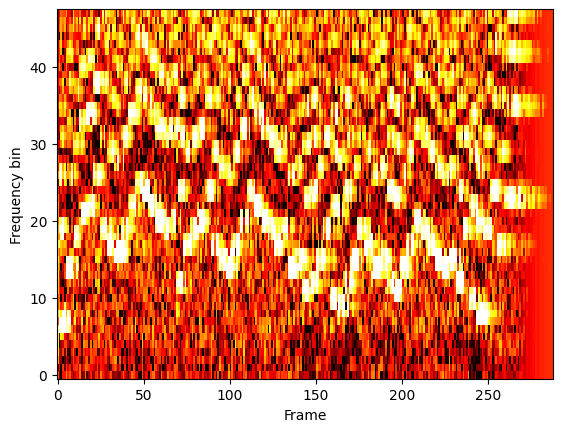

In [145]:
display_cqt(user_cqt)

## Step 3: Compute distance matrix

In [146]:
import scipy

distance_matrix = scipy.spatial.distance.cdist(midi_cqt, user_cqt, metric='cosine')
distance_matrix

array([[5.24657926e-07, 5.90564204e-02, 8.53740408e-02, ...,
        2.66867667e-02, 2.68291382e-02, 2.68475122e-02],
       [5.87363296e-02, 1.48819282e-06, 4.16512800e-02, ...,
        4.68192220e-02, 4.65363512e-02, 4.64993380e-02],
       [8.49391452e-02, 4.15195649e-02, 1.82633280e-06, ...,
        5.90975273e-02, 5.85234151e-02, 5.84550446e-02],
       ...,
       [2.67513320e-02, 4.85390259e-02, 6.09652669e-02, ...,
        1.45235012e-04, 2.78041448e-04, 3.06427425e-04],
       [2.68639607e-02, 4.70260388e-02, 5.92114143e-02, ...,
        9.05852366e-06, 2.53003553e-05, 3.58084062e-05],
       [2.70130051e-02, 4.70207224e-02, 5.91006209e-02, ...,
        4.02680619e-05, 1.12377253e-06, 1.11022302e-16]])

In [161]:
from dtw import *

# Define the step pattern (you can experiment with different step patterns)
step_pattern = symmetric1

# Define the Sakoe-Chiba band (you can adjust the window size as needed)
window_type = 'sakoechiba'
window_args = {'window_size': 100}

# Apply DTW on the distance matrix with the chosen step pattern and window
alignment = dtw(distance_matrix, keep_internals=True, step_pattern=step_pattern, window_type=window_type, window_args=window_args)

# Extract aligned CQT features using the alignment path
aligned_midi_cqt = midi_cqt[alignment.index1] 
aligned_user_cqt = user_cqt[alignment.index2] # Should not change much

aligned_midi_times = midi_times[alignment.index1]
aligned_user_times = user_times[alignment.index2]

# Compute the mean alignment error
mean_error = np.mean(np.abs(alignment.index1 - alignment.index2))

# Are these units true?
print("DTW alignment computed.")
print(f"Distance: {alignment.distance}") # unit = cosine distance
print(f"Mean alignment error: {mean_error}") # unit = frames

DTW alignment computed.
Distance: 8.979632973803506
Mean alignment error: 28.417241379310344


<Axes: xlabel='Query index', ylabel='Reference index'>

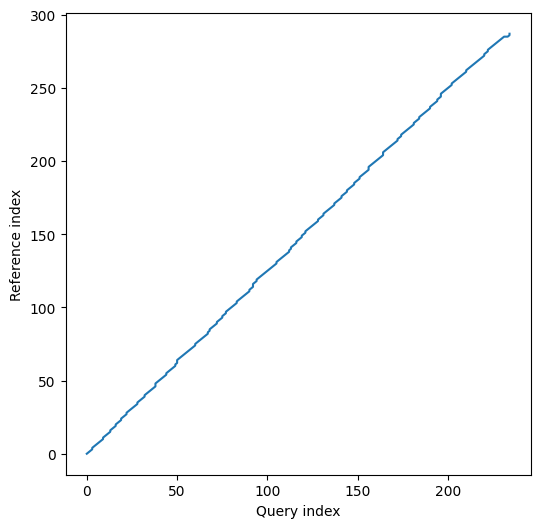

In [162]:
alignment.plot()

In [163]:
# alignment.index1 and alignment.index2 provide the warping path
for idx1, idx2 in zip(alignment.index1, alignment.index2):
    print(f"MIDI index: {idx1}, User index: {idx2}")

MIDI index: 0, User index: 0
MIDI index: 1, User index: 1
MIDI index: 2, User index: 2
MIDI index: 3, User index: 3
MIDI index: 3, User index: 4
MIDI index: 4, User index: 5
MIDI index: 5, User index: 6
MIDI index: 6, User index: 7
MIDI index: 7, User index: 8
MIDI index: 8, User index: 9
MIDI index: 9, User index: 10
MIDI index: 9, User index: 11
MIDI index: 10, User index: 12
MIDI index: 11, User index: 13
MIDI index: 12, User index: 14
MIDI index: 13, User index: 15
MIDI index: 13, User index: 16
MIDI index: 14, User index: 17
MIDI index: 15, User index: 18
MIDI index: 16, User index: 19
MIDI index: 16, User index: 20
MIDI index: 17, User index: 21
MIDI index: 18, User index: 22
MIDI index: 19, User index: 23
MIDI index: 19, User index: 24
MIDI index: 20, User index: 25
MIDI index: 21, User index: 26
MIDI index: 22, User index: 27
MIDI index: 22, User index: 28
MIDI index: 23, User index: 29
MIDI index: 24, User index: 30
MIDI index: 25, User index: 31
MIDI index: 26, User index: 32

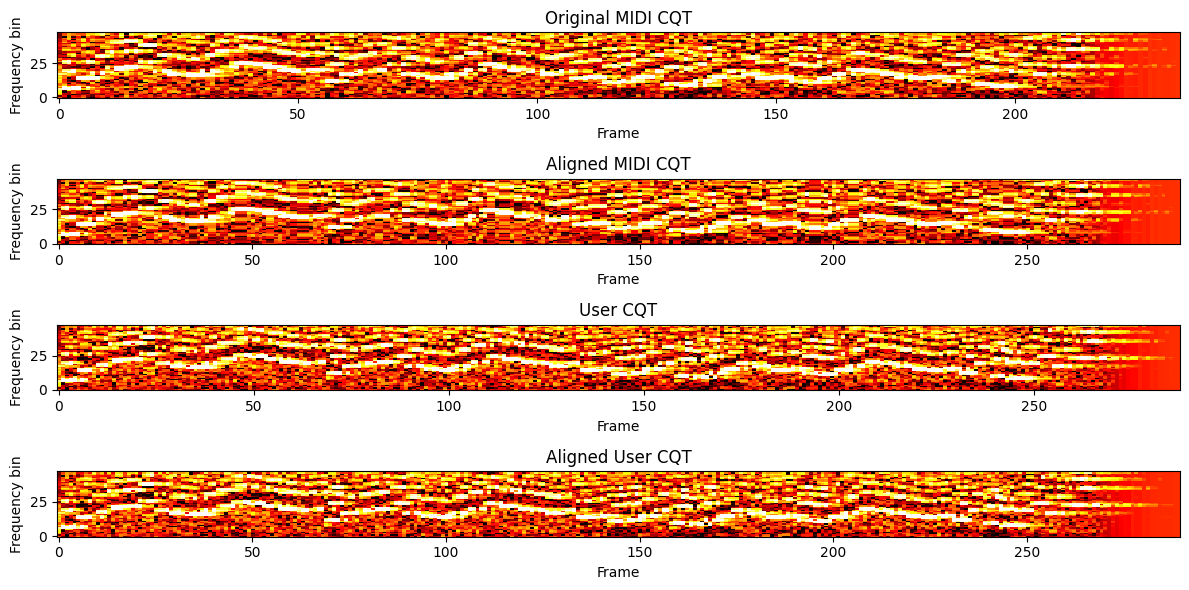

In [164]:
# Plot the original MIDI cqt, the aligned MIDI cqt, and the user cqt

plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)  
display_cqt(midi_cqt)
plt.title('Original MIDI CQT')

plt.subplot(4, 1, 2)  
display_cqt(aligned_midi_cqt)
plt.title('Aligned MIDI CQT')

plt.subplot(4, 1, 3) 
display_cqt(user_cqt)
plt.title('User CQT')

plt.subplot(4, 1, 4) 
display_cqt(aligned_user_cqt)
plt.title('Aligned User CQT')

plt.tight_layout()
plt.show()

In [165]:
# midi_cqt.shape[0]
# len(midi_times)

# print(f'midi_cqt.shape: {midi_cqt.shape}, len(midi_times): {len(midi_times)}')
# print(f'user_cqt.shape: {user_cqt.shape}, len(user_times): {len(user_times)}')

print(f'aligned_midi_times.shape: {aligned_midi_times.shape}')
# print(f'aligned_user_times.shape: {aligned_user_times.shape}')

print("Comparing the aligned MIDI times to the template user times\n---")
for midi_time, user_time in zip(aligned_midi_times, aligned_user_times):
    print(f"MIDI time: {midi_time}, User time: {user_time}")

aligned_midi_times.shape: (290,)
Comparing the aligned MIDI times to the template user times
---
MIDI time: 0.0, User time: 0.0
MIDI time: 0.046439909297052155, User time: 0.046439909297052155
MIDI time: 0.09287981859410431, User time: 0.09287981859410431
MIDI time: 0.13931972789115646, User time: 0.13931972789115646
MIDI time: 0.13931972789115646, User time: 0.18575963718820862
MIDI time: 0.18575963718820862, User time: 0.23219954648526078
MIDI time: 0.23219954648526078, User time: 0.2786394557823129
MIDI time: 0.2786394557823129, User time: 0.3250793650793651
MIDI time: 0.3250793650793651, User time: 0.37151927437641724
MIDI time: 0.37151927437641724, User time: 0.4179591836734694
MIDI time: 0.4179591836734694, User time: 0.46439909297052157
MIDI time: 0.4179591836734694, User time: 0.5108390022675737
MIDI time: 0.46439909297052157, User time: 0.5572789115646258
MIDI time: 0.5108390022675737, User time: 0.603718820861678
MIDI time: 0.5572789115646258, User time: 0.6501587301587302
MI

In [166]:
# Inspect pitch_df of the orignal MIDI file
message_dict, program_dict, pitch_df = MidiLoader.parse_midi('data/midi_files/fast_fugue_midi.mid')

pitch_df

,start,channel,pitch,velocity,duration
0,0.00,0,62,100,0.14875
1,0.15,0,69,100,0.14875
2,0.30,0,73,100,0.14875
3,0.45,0,76,100,0.14875
4,0.60,0,77,100,0.14875
...,...,...,...,...,...
60,9.00,0,63,100,0.14875
61,9.15,0,74,100,0.14875
62,9.30,0,79,100,0.14875
63,9.45,0,72,100,0.14875


In [167]:
# Create a new MIDI object for the aligned MIDI
import pandas as pd

def warp_midi(aligned_midi_times: np.ndarray, aligned_user_times: np.ndarray, pitch_df: pd.DataFrame) -> pretty_midi.PrettyMIDI:
    """
    Use the aligned MIDI / user audio times to create a new MIDI object 
    with notes aligned to the user audio.

    @param:
        - aligned_midi_times: np.array of aligned MIDI times
        - aligned_user_times: np.array of aligned user audio times
        - pitch_df: pd.DataFrame of MIDI note information
    """
    aligned_midi = pretty_midi.PrettyMIDI()
    
    VIOLIN_PROGRAM = 41
    violin_instrument = pretty_midi.Instrument(program=VIOLIN_PROGRAM, is_drum=False, name='Violin')

    for row_index, note in pitch_df.iterrows():

        print(f'WARPING PITCH: {note.pitch} @ TIME: {note.start}\n---')

        onset_time = note.start
        onset_idx = np.argmin(np.abs(aligned_midi_times - onset_time))
        
        if row_index == pitch_df.shape[0] - 1:
            # Get the length of the midi_audio
            og_next_onset_time = aligned_midi_times[-1]
        else:
            og_next_onset_time = pitch_df.iloc[row_index + 1].start

        next_onset_idx = np.argmin(np.abs(aligned_midi_times - og_next_onset_time))
        next_onset_time = og_next_onset_time

        print(f'onset_idx: {onset_idx}, next_onset_idx: {next_onset_idx}')
        print(f'onset_time: {onset_time}, next_onset_time: {next_onset_time}')

        warped_onset_time = aligned_user_times[onset_idx]
        warped_next_onset_time = aligned_user_times[next_onset_idx]

        print(f'warped_onset_time: {warped_onset_time}, warped_next_onset_time: {warped_next_onset_time}\n')

        original_internote_duration = next_onset_time - onset_time
        aligned_internote_duration = warped_next_onset_time - warped_onset_time
        warp_ratio = aligned_internote_duration / original_internote_duration

        original_note_duration = note.duration
        warped_note_duration = original_note_duration * warp_ratio

        print(f'original_internote_duration: {original_internote_duration} -> warped_internote_duration: {aligned_internote_duration}')
        print(f'original_note_duration: {original_note_duration} -> warped_note_duration: {warped_note_duration}\n')

        pitch = int(note.pitch)
        velocity = int(note.velocity)

        print(f'> Adding note {pitch} @ time {warped_onset_time} with duration {warped_note_duration}\n')
        new_note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=warped_onset_time, end=warped_onset_time+warped_note_duration)
        violin_instrument.notes.append(new_note)

        aligned_midi.instruments.append(violin_instrument)

    return aligned_midi

   
aligned_midi = warp_midi(aligned_midi_times, aligned_user_times, pitch_df)

# Save the aligned MIDI to a file
aligned_midi.write("data/midi_files/midi2midi_aligned_fast_fugue.mid")


WARPING PITCH: 62.0 @ TIME: 0.0
---
onset_idx: 0, next_onset_idx: 3
onset_time: 0.0, next_onset_time: 0.15
warped_onset_time: 0.0, warped_next_onset_time: 0.13931972789115646

original_internote_duration: 0.15 -> warped_internote_duration: 0.13931972789115646
original_note_duration: 0.14875 -> warped_note_duration: 0.13815873015873015

> Adding note 62 @ time 0.0 with duration 0.13815873015873015

WARPING PITCH: 69.0 @ TIME: 0.15
---
onset_idx: 3, next_onset_idx: 7
onset_time: 0.15, next_onset_time: 0.29999999999999993
warped_onset_time: 0.13931972789115646, warped_next_onset_time: 0.3250793650793651

original_internote_duration: 0.14999999999999994 -> warped_internote_duration: 0.18575963718820862
original_note_duration: 0.14874999999999997 -> warped_note_duration: 0.18421164021164024

> Adding note 69 @ time 0.13931972789115646 with duration 0.18421164021164024

WARPING PITCH: 73.0 @ TIME: 0.29999999999999993
---
onset_idx: 7, next_onset_idx: 12
onset_time: 0.29999999999999993, next_

## Inspect the result

In [168]:
# Initialize a MidiSynth + MidiPlayer with a given soundfont
SOUNDFONT = 'data/MuseScore_General.sf3'
midi_synth = MidiSynth(soundfont_path=SOUNDFONT)
midi_player = MidiPlayer(midi_synth)

# Play a given midi file
MIDI_FILEPATH = 'data/midi_files/midi2midi_aligned_fast_fugue.mid'
midi_player.load_midi(MIDI_FILEPATH)
midi_player.play(start_time=0)

In [130]:
midi_player.pause()

In [134]:
aligned_message_dict, aligned_program_dict, aligned_pitch_df = MidiLoader.parse_midi('data/aligned_fast_fugue.mid')

aligned_pitch_df

,start,channel,pitch,velocity,duration
0,0.000000,0,62,100,0.229545
1,0.231818,0,69,100,0.093182
2,0.325000,0,73,100,0.322727
3,0.650000,0,76,100,0.138636
4,0.788636,0,77,100,0.138636
...,...,...,...,...,...
59,11.331818,0,65,100,0.184091
60,11.518182,0,63,100,0.368182
61,11.888636,0,79,100,0.184091
62,12.075000,0,72,100,0.322727


In [137]:
import librosa
import sounddevice as sd
from time import sleep

AUDIO_FILEPATH = 'data/audio_files/fugue_recording.mp3'
FS_SAMPLE_RATE = 22050

# Load the MP3 file
user_audio, user_sample_rate = librosa.load(AUDIO_FILEPATH, sr=FS_SAMPLE_RATE)

for row_index, note in aligned_pitch_df.iterrows():
    user_start_idx = int(note.start * FS_SAMPLE_RATE)
    user_end_idx = int((note.start + note.duration) * FS_SAMPLE_RATE)

    audio_slice = user_audio[user_start_idx:user_end_idx]
    sd.play(audio_slice, FS_SAMPLE_RATE)
    sd.wait()

    sleep(0.5)


In [133]:
# Play the template audio
audio_player = AudioPlayer()

# Play a given audio file
AUDIO_FILEPATH = 'data/fugue_recording.mp3'
audio_player.load_audio(AUDIO_FILEPATH)
audio_player.play()